In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Dropout, Bidirectional, CuDNNGRU, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D, Input, concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import os


print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['sample_submission.csv', 'train.json', 'test.json']


In [2]:
df_train=pd.read_json('../input/train.json')
df_test=pd.read_json('../input/test.json')

In [3]:
print(df_train.shape[0])
print(df_test.shape[0])

1195
1196


In [4]:
df_train.head()

,audio_embedding,end_time_seconds_youtube_clip,is_turkey,start_time_seconds_youtube_clip,vid_id
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",70,0,60,kDCk3hLIVXo
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",40,1,30,DPcGzqHoo7Y
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",240,1,230,7yM63MTHh5k
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",520,1,510,luG3RmUAxxM
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",10,0,0,PIm3cjxTpOk


In [5]:
df_test.head()

,audio_embedding,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip,vid_id
0,"[[177, 20, 226, 132, 198, 81, 111, 59, 132, 18...",10,0,pyKh38FXD3E
1,"[[169, 21, 204, 161, 195, 72, 60, 39, 152, 184...",40,30,THhP1idrWXA
2,"[[165, 13, 198, 141, 199, 81, 173, 54, 119, 11...",40,30,jsw3T6GY2Nw
3,"[[167, 18, 188, 159, 198, 63, 156, 36, 179, 22...",24,14,nFkXTMHcjMU
4,"[[178, 32, 181, 100, 198, 46, 82, 83, 136, 227...",40,30,Au8g9kAlrLQ


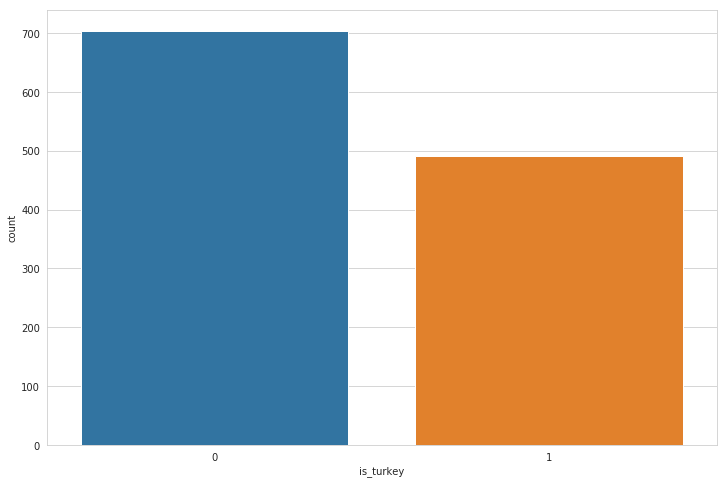

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(df_train['is_turkey'])
plt.show()

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 5 columns):
audio_embedding                    1195 non-null object
end_time_seconds_youtube_clip      1195 non-null int64
is_turkey                          1195 non-null int64
start_time_seconds_youtube_clip    1195 non-null int64
vid_id                             1195 non-null object
dtypes: int64(3), object(2)
memory usage: 46.8+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 4 columns):
audio_embedding                    1196 non-null object
end_time_seconds_youtube_clip      1196 non-null int64
start_time_seconds_youtube_clip    1196 non-null int64
vid_id                             1196 non-null object
dtypes: int64(2), object(2)
memory usage: 37.5+ KB


In [9]:
df_train['length']=df_train['audio_embedding'].apply(len)

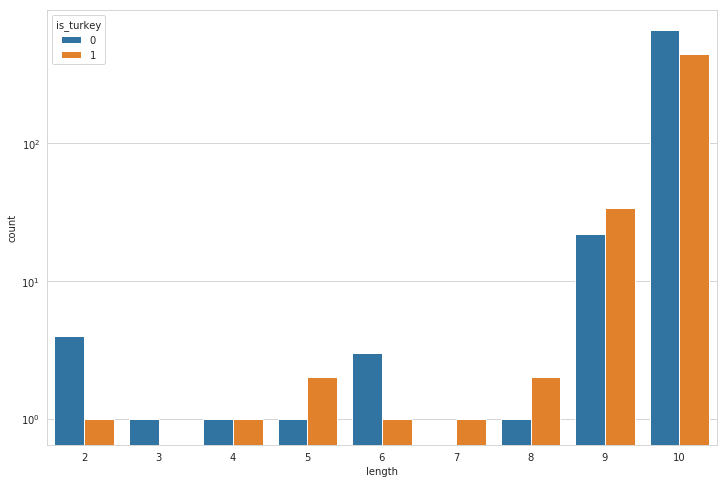

In [10]:
plt.figure(figsize=(12,8))
plt.yscale('log')
sns.countplot('length',hue='is_turkey',data=df_train)
plt.show()

In [11]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [12]:
max_len=10
feature_size=128

In [13]:
x=pad_sequences(df_train['audio_embedding'],maxlen=max_len,padding='post')
#dataframe每一列本质是一个列表
x_test=pad_sequences(df_test['audio_embedding'],maxlen=max_len,padding='post')

In [14]:
y=df_train['is_turkey'].values
#print(y)

In [15]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2)

In [16]:
print(x_train.shape[0])

956


In [17]:
print(df_train['audio_embedding'][1])

[[169, 20, 165, 102, 205, 62, 110, 103, 211, 187, 53, 132, 120, 156, 9, 105, 156, 69, 147, 145, 3, 165, 95, 44, 112, 77, 178, 185, 146, 0, 30, 0, 68, 102, 144, 123, 0, 58, 169, 108, 0, 53, 36, 0, 227, 248, 21, 122, 0, 255, 249, 138, 37, 182, 133, 103, 230, 74, 18, 121, 0, 140, 4, 209, 117, 252, 59, 78, 153, 196, 104, 74, 255, 255, 63, 0, 130, 0, 0, 145, 52, 255, 255, 255, 255, 205, 66, 78, 0, 0, 0, 255, 6, 171, 39, 255, 237, 0, 255, 47, 173, 10, 103, 216, 119, 255, 65, 0, 206, 19, 0, 0, 0, 112, 73, 27, 124, 255, 0, 0, 32, 76, 99, 73, 255, 174, 32, 255], [175, 19, 155, 106, 210, 82, 109, 106, 202, 210, 77, 120, 122, 142, 53, 80, 138, 108, 151, 161, 11, 158, 95, 19, 88, 125, 221, 185, 142, 48, 47, 36, 129, 167, 96, 167, 0, 88, 162, 143, 48, 75, 26, 69, 177, 212, 37, 120, 0, 255, 220, 182, 40, 191, 54, 133, 214, 121, 75, 185, 57, 114, 0, 185, 108, 198, 76, 96, 175, 154, 149, 71, 255, 255, 91, 38, 89, 91, 67, 128, 112, 255, 255, 211, 211, 201, 102, 142, 3, 6, 26, 255, 8, 212, 28, 255, 152,

In [18]:
def build_model():
    inp = Input(shape=(max_len, feature_size))
    x = BatchNormalization()(inp)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pool, max_pool])
    concat = Dense(64, activation="relu")(concat)
    concat = Dropout(0.5)(concat)
    output = Dense(1, activation="sigmoid")(concat)
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

In [19]:
model=build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 128)      0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 10, 128)      512         input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 256)      198144      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 10, 128)      123648      bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_ave

In [21]:
rlr=ReduceLROnPlateau(monitor='val_acc',factor=0.1,patience=2,verbose=1,min_lr=1e-8)

In [22]:
epochs=30

In [23]:
H=model.fit(x_train,y_train,epochs=epochs,batch_size=256,validation_data=[x_val,y_val],verbose=2,callbacks=[rlr])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 956 samples, validate on 239 samples
Epoch 1/30
 - 5s - loss: 0.6842 - acc: 0.5795 - val_loss: 0.6025 - val_acc: 0.7615
Epoch 2/30
 - 0s - loss: 0.6018 - acc: 0.7008 - val_loss: 0.5339 - val_acc: 0.8494
Epoch 3/30
 - 0s - loss: 0.5332 - acc: 0.7929 - val_loss: 0.4741 - val_acc: 0.8996
Epoch 4/30
 - 0s - loss: 0.4941 - acc: 0.8253 - val_loss: 0.4221 - val_acc: 0.9331
Epoch 5/30
 - 0s - loss: 0.4331 - acc: 0.8703 - val_loss: 0.3766 - val_acc: 0.9331
Epoch 6/30
 - 0s - loss: 0.3823 - acc: 0.8985 - val_loss: 0.3365 - val_acc: 0.9414
Epoch 7/30
 - 0s - loss: 0.3539 - acc: 0.9059 - val_loss: 0.3018 - val_acc: 0.9372
Epoch 8/30
 - 0s - loss: 0.3289 - acc: 0.9079 - val_loss: 0.2718 - val_acc: 0.9372

Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 9/30
 - 0s - loss: 0.3016 - acc: 0.9331 - val_loss: 0.2691 - val_acc: 0.9331


In [24]:
def show_train_history(H):
    plt.style.use("ggplot")
    plt.figure()
    N = len(H.epoch) # 训练周期数
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Loss and Accuracy ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig('plot.png')
plt.show()


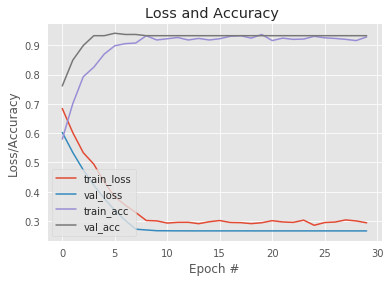

In [25]:
show_train_history(H)

In [26]:
model.evaluate(x_val,y_val,verbose=1)

239/239 [==============================] - 0s 139us/step


[0.2658851055669984, 0.933054393804223]

In [27]:
model_final=build_model()
HH=model_final.fit(x,y,epochs=30,batch_size=256,verbose=1)

Epoch 1/30
1195/1195 [==============================] - 1s 989us/step - loss: 0.6586 - acc: 0.6017
Epoch 2/30
1195/1195 [==============================] - 0s 44us/step - loss: 0.5781 - acc: 0.7322
Epoch 3/30
1195/1195 [==============================] - 0s 47us/step - loss: 0.4851 - acc: 0.8218
Epoch 4/30
1195/1195 [==============================] - 0s 44us/step - loss: 0.4303 - acc: 0.8644
Epoch 5/30
1195/1195 [==============================] - 0s 44us/step - loss: 0.3726 - acc: 0.8962
Epoch 6/30
1195/1195 [==============================] - 0s 48us/step - loss: 0.3402 - acc: 0.9105
Epoch 7/30
1195/1195 [==============================] - 0s 45us/step - loss: 0.2938 - acc: 0.9297
Epoch 8/30
1195/1195 [==============================] - 0s 45us/step - loss: 0.2635 - acc: 0.9264
Epoch 9/30
1195/1195 [==============================] - 0s 47us/step - loss: 0.2419 - acc: 0.9356
Epoch 10/30
1195/1195 [==============================] - 0s 44us/step - loss: 0.2145 - acc: 0.9431
Epoch 11/30
1195/1

In [28]:
y_test=model_final.predict(x_test,verbose=1)

1196/1196 [==============================] - 0s 314us/step


In [29]:
print(y_test)

[[1.6252398e-03]
 [7.8639388e-04]
 [1.0099977e-02]
 ...
 [9.9429166e-01]
 [2.1308243e-02]
 [1.5514135e-02]]


In [30]:
print(type(y_test))

<class 'numpy.ndarray'>


In [31]:
"""
y_test2=list(y_test)
print(y_test2)
print(type(y_test2))
"""

'\ny_test2=list(y_test)\nprint(y_test2)\nprint(type(y_test2))\n'

In [32]:
result=pd.DataFrame({'vid_id':df_test['vid_id'].values,'is_turkey':list(y_test.flatten())})

In [33]:
result.head()

,vid_id,is_turkey
0,pyKh38FXD3E,0.001625
1,THhP1idrWXA,0.000786
2,jsw3T6GY2Nw,0.010100
3,nFkXTMHcjMU,0.003222
4,Au8g9kAlrLQ,0.846170


In [34]:
result.to_csv('result.csv',index=False)